# Kannst du durch pures Glück in einen viel höheren Rank kommen?

Stell dir einen League-Spieler vor, der bei seiner eigenen Elo (50% Winrate) beginnt. Er kann nicht besser oder schlechter werden, seine MMR entspricht immer seiner Elo. Das sind alles starke Vereinfachungen, aber wir müssen das Problem etwas leichter machen.

**Die Frage:** Kannst du es schaffen, durch pures Glück und gute Teammates weit über dein eigentliches Level zu kommen? In diesem Fall, kann ein durchschnittlicher Spieler 100 Wins mehr als Losses erreichen?

**Das Problem:** Je höher dein Rank wird, desto schwerer werden die Gegner. Deine Winchance sinkt von 50% am Anfang auf nur noch 15% bei 100 Wins. Aber wenn du unter deinem Start-Rank fällst, wird's wieder leichter (mehr als 50% Winchance).

## Die Rechnung

Die Winchance ändert sich so: `Winchance = 50% - (0,35% × deine Punkte)`

Das bedeutet:
- **Bei 0 Punkten:** 50% Winchance (fair)
- **Bei 50 Punkten:** 32,5% Winchance (wird schwer)
- **Bei 100 Punkten:** 15% Winchance (fast unmöglich)
- **Bei -50 Punkten:** 67,5% Winchance (leichter zu recovern)

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import numba
from joblib import Parallel, delayed

np.random.seed(42)
random.seed(42)

In [4]:
@numba.jit(nopython=True)
def get_winrate(points):
    winrate = 0.5 - (points * 0.0035)
    return max(0.01, min(0.99, winrate))

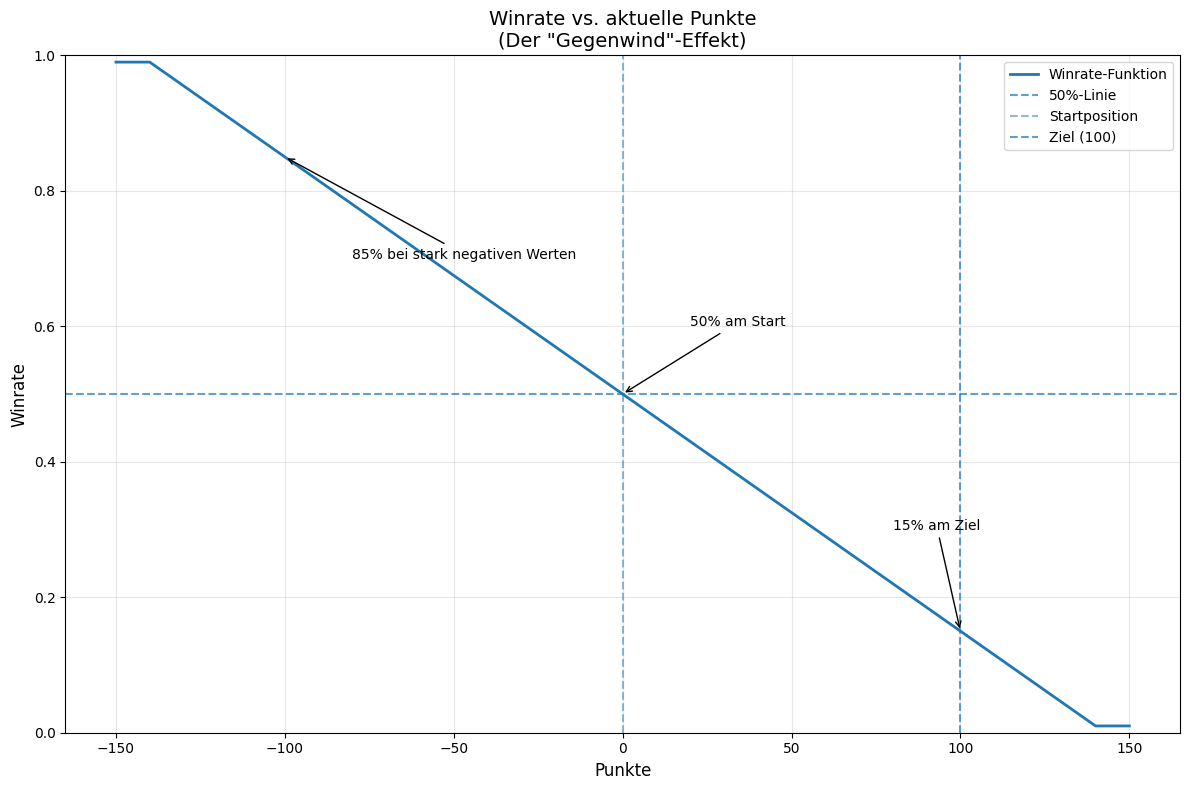

In [5]:
def plot_winrate_function():
    points = np.linspace(-150, 150, 301)
    winrates = [get_winrate(p) for p in points]

    plt.figure(figsize=(12, 8))
    plt.plot(points, winrates, linewidth=2, label='Winrate-Funktion')

    plt.axhline(y=0.5, linestyle='--', alpha=0.7, label='50%-Linie')
    plt.axvline(x=0, linestyle='--', alpha=0.5, label='Startposition')
    plt.axvline(x=100, linestyle='--', alpha=0.7, label='Ziel (100)')

    plt.xlabel('Punkte', fontsize=12)
    plt.ylabel('Winrate', fontsize=12)
    plt.title('Winrate vs. aktuelle Punkte\n(Der "Gegenwind"-Effekt)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)

    plt.annotate('50% am Start', (0, 0.5), xytext=(20, 0.6),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)
    plt.annotate('15% am Ziel', (100, 0.15), xytext=(80, 0.3),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)
    plt.annotate('85% bei stark negativen Werten', (-100, 0.85), xytext=(-80, 0.7),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)

    plt.tight_layout()
    plt.show()

plot_winrate_function()

In [7]:
@numba.jit(nopython=True)
def simulate_single_run(target=100, max_steps=50000, track_path=False):
    points = 0
    steps = 0
    min_points = 0
    
    if track_path:
        path = [0]
    else:
        path = None

    while steps < max_steps:
        if points >= target:
            return 1, steps, min_points, path

        winrate = get_winrate(points)
        if np.random.random() < winrate:
            points += 1
        else:
            points -= 1
            min_points = min(min_points, points)

        if track_path:
            path.append(points)

        steps += 1

    return 0, steps, min_points, path

In [10]:
def run_single_simulation(target, max_steps, track_this_run=False):
    return simulate_single_run(target, max_steps, track_path=track_this_run)

def run_simulation(num_runs=100000, target=100, verbose=True, n_jobs=-1):
    from collections import defaultdict
    results = defaultdict(int)
    successful_steps = []
    successful_min_points = []
    tracked_paths = []

    if verbose:
        print(f"{'='*50}")
        print(f"Ziel: {target} Punkte")
        print(f"Durchläufe: {num_runs:,}")
        print(f"{'='*50}")

        start_time = time.time()

    track_indices = set(range(0, num_runs, 1000))
    
    simulation_results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(run_single_simulation)(target, 50000, i in track_indices) for i in range(num_runs)
    )

    for i, sim_result in enumerate(simulation_results):
        result, steps, min_points, path = sim_result
        
        if i in track_indices and path is not None:
            tracked_paths.append({
                'run_id': i,
                'result': result,
                'steps': steps,
                'min_points': min_points,
                'path': path
            })
            
        if result == 1:
            results['success'] += 1
            successful_steps.append(steps)
            successful_min_points.append(min_points)
        else:
            results['timeout'] += 1

    total_runs = sum(results.values())
    escape_prob = results['success'] / total_runs if total_runs else 0.0
    timeout_rate = results['timeout'] / total_runs if total_runs else 0.0

    if verbose:
        elapsed = time.time() - start_time
        print(f"{'='*50}")
        print(f"Erfolgreiche Durchläufe: {results['success']:,}")
        print(f"Abgebrochene Durchläufe aka 50000 Spiele ohne 100 Wins mehr als Losses zu erreichen (Timeout): {results['timeout']:,}")
        print(f"{'='*50}")



    detailed_results = {
        'escape_probability': escape_prob,
        'successful_steps': successful_steps,
        'successful_min_points': successful_min_points,
        'timeout_rate': timeout_rate,
        'tracked_paths': tracked_paths,
        'raw_results': dict(results)
    }

    return escape_prob, detailed_results

In [11]:
escape_probability, results = run_simulation(num_runs=10000000, target=100)

Ziel: 100 Punkte
Durchläufe: 10,000,000
Erfolgreiche Durchläufe: 0
Abgebrochene Durchläufe aka 50000 Spiele ohne 100 Wins mehr als Losses zu erreichen (Timeout): 10,000,000


## Das Ergebnis: Unmöglicher Rank-Boost

Nach 10 Millionen Versuchen: Kein einziger Spieler hat es geschafft.

Natürlich ist es theoretisch möglich. Bei unendlich Spielen würde sogar eine 1000 Spiele Winstreak irgendwann auftreten. Aber halt nur bei unendlich Versuchen.

Aber praktisch? Selbst bei 10 Millionen simulierten Spielern (jeder davon mit 50000 Spielen) haben wir keinen einzigen Erfolg gesehen. Die Wahrscheinlichkeit ist also extrem gering.

Die einzige Möglichkeit zu climben ist und bleibt besser werden :)

Three Random Walk Examples:
  Path 1: Final point: 0, Min point: -24, Steps: 10000
  Path 2: Final point: -10, Min point: -19, Steps: 10000
  Path 3: Final point: -2, Min point: -25, Steps: 10000

Simulation Statistics:
  Successful paths: 0 of 10000
  Average lowest point: -30.3
  Most extreme drop: -51


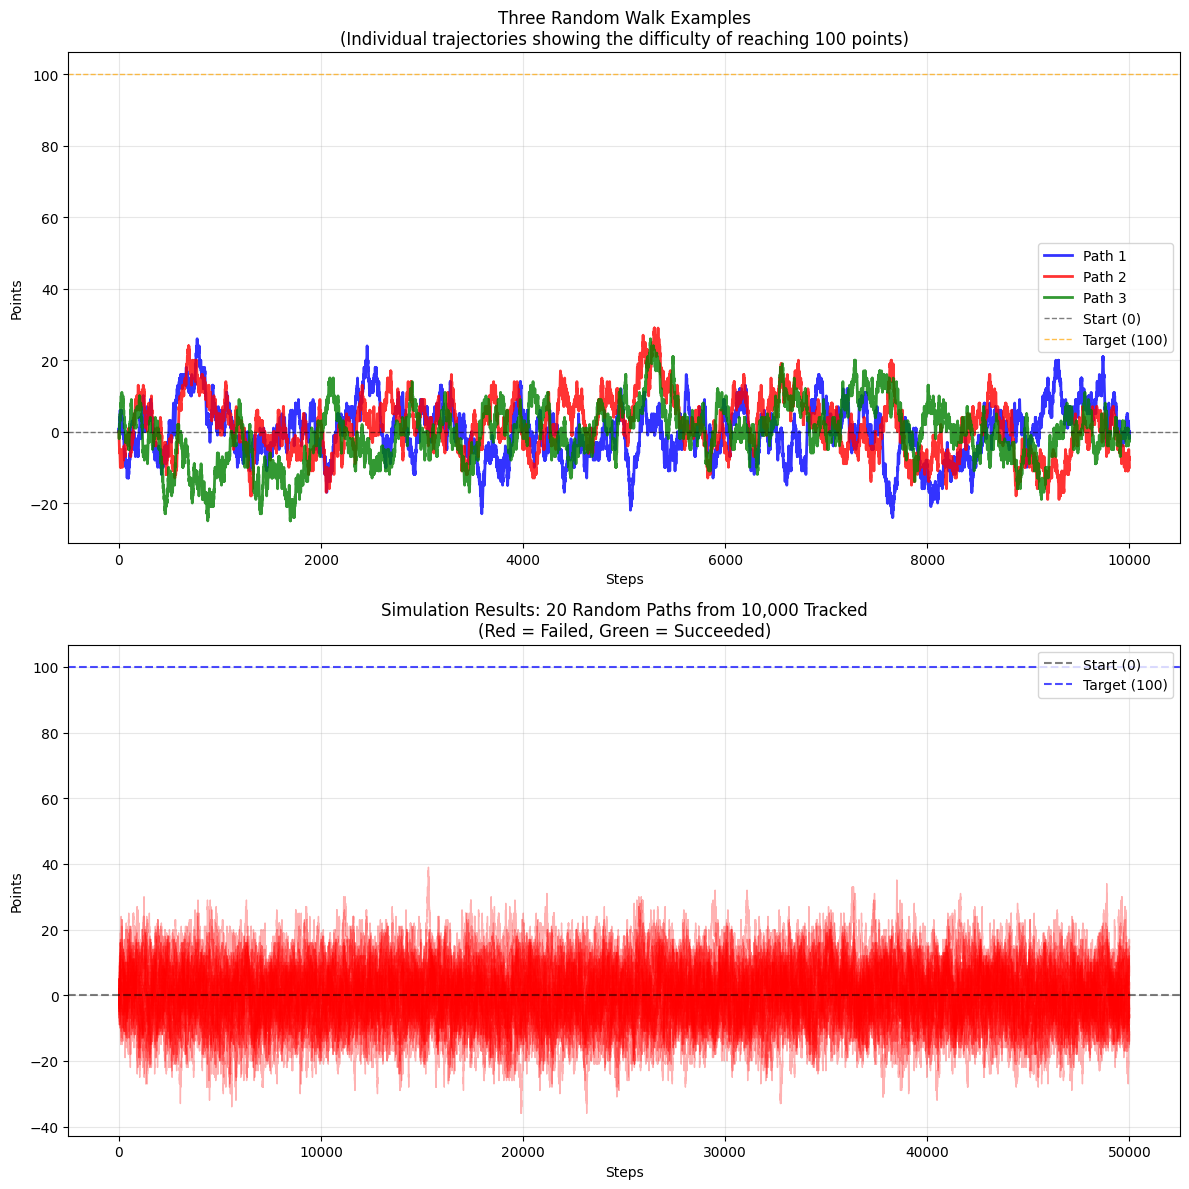

In [13]:
def plot_combined_paths_analysis(detailed_results, max_paths=10):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    colors = ['blue', 'red', 'green']
    labels = ['Path 1', 'Path 2', 'Path 3']
    
    print("Three Random Walk Examples:")
    for i in range(3):
        np.random.seed(42 + i * 10)
        
        result, steps, min_points, path = simulate_single_run(target=100, max_steps=10000, track_path=True)
        
        if path:
            ax1.plot(range(len(path)), path, color=colors[i], label=labels[i], linewidth=2, alpha=0.8)
            
            final_point = path[-1] if path else 0
            print(f"  {labels[i]}: Final point: {final_point}, Min point: {min_points}, Steps: {len(path)-1}")
    
    ax1.axhline(y=0, linestyle='--', alpha=0.5, color='black', label='Start (0)', linewidth=1)
    ax1.axhline(y=100, linestyle='--', alpha=0.7, color='orange', label='Target (100)', linewidth=1)
    
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Points')
    ax1.set_title('Three Random Walk Examples\n(Individual trajectories showing the difficulty of reaching 100 points)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    tracked_paths = detailed_results['tracked_paths']
    
    if tracked_paths:
        paths_to_plot = min(max_paths, len(tracked_paths))
        for i in range(paths_to_plot):
            path_data = tracked_paths[i]
            path = path_data['path']
            steps = len(path)
            
            color = 'green' if path_data['result'] == 1 else 'red'
            alpha = 0.7 if path_data['result'] == 1 else 0.3
            
            ax2.plot(range(steps), path, alpha=alpha, color=color, linewidth=1)
        
        ax2.axhline(y=0, linestyle='--', alpha=0.5, color='black', label='Start (0)')
        ax2.axhline(y=100, linestyle='--', alpha=0.7, color='blue', label='Target (100)')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Points')
        ax2.set_title(f'Simulation Results: {paths_to_plot} Random Paths from {len(tracked_paths):,} Tracked\n(Red = Failed, Green = Succeeded)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        print(f"\nSimulation Statistics:")
        print(f"  Successful paths: {sum(1 for p in tracked_paths if p['result'] == 1)} of {len(tracked_paths)}")
        min_points = [p['min_points'] for p in tracked_paths]
        print(f"  Average lowest point: {np.mean(min_points):.1f}")
        print(f"  Most extreme drop: {min(min_points)}")
    else:
        ax2.text(0.5, 0.5, 'No tracked paths available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('No Tracked Paths Available')
    
    plt.tight_layout()
    plt.show()

plot_combined_paths_analysis(results, max_paths=20)